# SimNet Training for Balancing Robot

This notebook trains a SimNet model using both physics simulation data and real-world data.

In [1]:
# Uncomment the following lines to run in Google Colab

# %cd /content
# !git clone https://github.com/EyalPorat/ddpg-balancing-robot.git
# %cd ddpg-balancing-robot
# !git checkout simpler-state-3
# %cd /content/ddpg-balancing-robot/python/notebooks

# import sys
# sys.path.append('/content/ddpg-balancing-robot/python')  # Add the repo root to Python path

In [2]:
import sys
sys.path.append('..')

import torch
import numpy as np
from pathlib import Path
import json
import yaml
import glob
from matplotlib import pyplot as plt
import seaborn as sns

from src.balancing_robot.models import SimNet
from src.balancing_robot.environment import BalancerEnv
from src.balancing_robot.training import SimNetTrainer
from src.balancing_robot.visualization import plot_predictions_comparison

## Load Configuration

In [3]:
# Load configurations
with open('../configs/simnet_config.yaml', 'r') as f:
    simnet_config = yaml.safe_load(f)

with open('../configs/env_config.yaml', 'r') as f:
    env_config = yaml.safe_load(f)

# Create directories
log_dir = Path('logs/simnet_training')
log_dir.mkdir(parents=True, exist_ok=True)

## Initialize Models and Environment

In [4]:
# Set random seeds
torch.manual_seed(simnet_config['data_collection']['random_seed'])
np.random.seed(simnet_config['data_collection']['random_seed'])

# Create environment for physics data
env = BalancerEnv(config_path='../configs/env_config.yaml')

# Initialize trainer with config
trainer = SimNetTrainer(
    env=env,
    config_path='../configs/simnet_config.yaml'
)

c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


## Collect and Process Physics Data

In [5]:
# Collect physics simulation data
train_data, val_data = trainer.collect_physics_data()

print(f"Collected {len(train_data['states'])} training samples")
print(f"Collected {len(val_data['states'])} validation samples")

Collected 819948 training samples
Collected 204987 validation samples


## Analyze Pre-Processed Data

Physics data distribution statistics:
  angle_range: (-1.7841, 1.7955)
  angle_mean: 0.0040
  angle_std: 0.7982
  angular_vel_range: (-22.8645, 22.9728)
  angular_vel_mean: 0.0274
  angular_vel_std: 4.3044
  num_samples: 819948.0000
  min_weight: 0.0000
  max_weight: 0.0000
  mean_weight: 0.0000
  std_weight: 0.0000


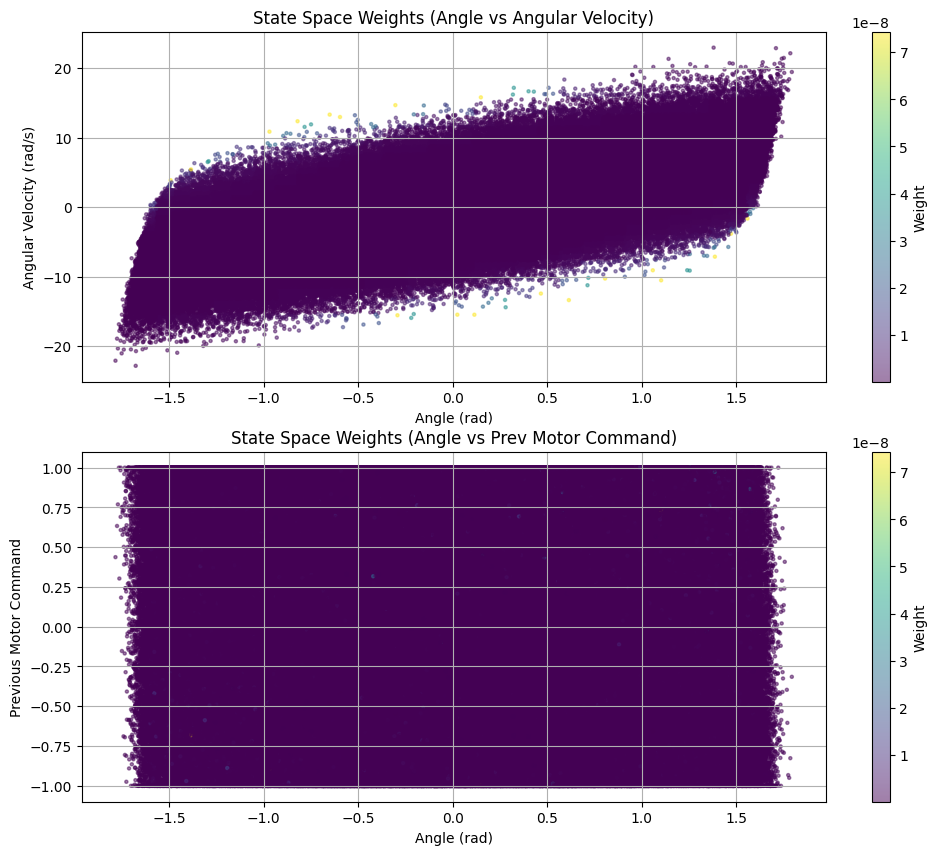

In [6]:
# Define class balancing parameters
num_bins = 30
strategy = "kmeans"

# Get distribution statistics
physics_distribution = SimNetTrainer.analyze_class_distribution(
    train_data, 
    num_bins=num_bins,
    strategy=strategy
)

print("Physics data distribution statistics:")
for key, value in physics_distribution.items():
    if isinstance(value, tuple):
        print(f"  {key}: ({value[0]:.4f}, {value[1]:.4f})")
    else:
        print(f"  {key}: {value:.4f}")

# Visualize class weights using angle and angular velocity
states = train_data['states']

# Create 2D scatter plot with first two dimensions (theta and theta_dot)
plt.figure(figsize=(12, 10))

# Create a figure with multiple subplots to show different state dimensions
plt.subplot(2, 1, 1)
weights = SimNetTrainer.calculate_class_weights(
    states, 
    num_bins=num_bins, 
    strategy=strategy
)
plt.scatter(states[:, 0], states[:, 1], c=weights, cmap='viridis', alpha=0.5, s=5)
plt.colorbar(label='Weight')
plt.title(f'State Space Weights (Angle vs Angular Velocity)')
plt.xlabel('Angle (rad)')
plt.ylabel('Angular Velocity (rad/s)')
plt.grid(True)

# Add a subplot for the angle vs prev_motor_command
plt.subplot(2, 1, 2)
plt.scatter(states[:, 0], states[:, 2], c=weights, cmap='viridis', alpha=0.5, s=5)
plt.colorbar(label='Weight')
plt.title(f'State Space Weights (Angle vs Prev Motor Command)')
plt.xlabel('Angle (rad)')
plt.ylabel('Previous Motor Command')
plt.grid(True)

## Balance Data and Analyze Again

In [7]:
# Create a balanced dataset through oversampling
# print("Creating balanced dataset through oversampling...")
# balanced_train_data = SimNetTrainer.create_balanced_dataset(
#     train_data, 
#     num_bins=num_bins, 
#     strategy=strategy
# )

# print(f"Original dataset size: {len(train_data['states'])} samples")
# print(f"Balanced dataset size: {len(balanced_train_data['states'])} samples")

# # Compare distributions
# plt.figure(figsize=(16, 6))

# plt.subplot(1, 2, 1)
# plt.scatter(train_data['states'][:, 0], train_data['states'][:, 1], alpha=0.1, s=1)
# plt.title('Original Training Data Distribution')
# plt.xlabel('Angle (rad)')
# plt.ylabel('Angular Velocity (rad/s)')
# plt.grid(True)

# plt.subplot(1, 2, 2)
# plt.scatter(balanced_train_data['states'][:, 0], balanced_train_data['states'][:, 1], 
#             alpha=0.1, s=1, c='orange')
# plt.title('Balanced Training Data Distribution')
# plt.xlabel('Angle (rad)')
# plt.ylabel('Angular Velocity (rad/s)')
# plt.grid(True)

# plt.tight_layout()
# plt.savefig(log_dir / "balanced_vs_original_distribution.png")
# plt.show()

## Train on Physics Data

In [8]:
# Train on physics data
physics_history = trainer.train(
    # train_data=balanced_train_data,
    train_data=train_data,
    val_data=val_data,
    is_finetuning=False,
    log_dir=log_dir / 'physics'
)

Epoch 1/30 - Train Loss: 3.072439 - Val Loss: 1.648306
Epoch 2/30 - Train Loss: 0.991779 - Val Loss: 0.569359
Epoch 3/30 - Train Loss: 0.380006 - Val Loss: 0.266242
Epoch 4/30 - Train Loss: 0.183555 - Val Loss: 0.127384
Epoch 5/30 - Train Loss: 0.087329 - Val Loss: 0.061906
Epoch 6/30 - Train Loss: 0.042383 - Val Loss: 0.030723
Epoch 7/30 - Train Loss: 0.021375 - Val Loss: 0.016242
Epoch 8/30 - Train Loss: 0.011749 - Val Loss: 0.009523
Epoch 9/30 - Train Loss: 0.007314 - Val Loss: 0.006353
Epoch 10/30 - Train Loss: 0.005201 - Val Loss: 0.004797
Epoch 11/30 - Train Loss: 0.004115 - Val Loss: 0.003951
Epoch 12/30 - Train Loss: 0.003499 - Val Loss: 0.003440
Epoch 13/30 - Train Loss: 0.003110 - Val Loss: 0.003096
Epoch 14/30 - Train Loss: 0.002846 - Val Loss: 0.002853
Epoch 15/30 - Train Loss: 0.002655 - Val Loss: 0.002666
Epoch 16/30 - Train Loss: 0.002505 - Val Loss: 0.002509
Epoch 17/30 - Train Loss: 0.002383 - Val Loss: 0.002385
Epoch 18/30 - Train Loss: 0.002281 - Val Loss: 0.002285
E

In [9]:
# Save physics trained SimNet
torch.save({
    'state_dict': trainer.simnet.state_dict(),
    'physics_history': physics_history,
    'config': simnet_config,
    'metadata': {
        'state_dim': env.observation_space.shape[0],
        'action_dim': env.action_space.shape[0],
        'hidden_dims': simnet_config['model']['hidden_dims']
    }
}, log_dir / 'simnet_physics_final.pt')

simnet_physics = SimNet(
    state_dim=env.observation_space.shape[0],
    action_dim=env.action_space.shape[0],
    hidden_dims=simnet_config['model']['hidden_dims']
)
simnet_physics.load_state_dict(torch.load(log_dir / 'simnet_physics_final.pt')['state_dict'])

<All keys matched successfully>

## Load and Process Real-World Data

In [10]:
# Find all files that start with robot_logs and end with .json
log_files = glob.glob('../data/robot_logs*.json')
print(f"Found {len(log_files)} log files: {log_files}")

# Initialize empty list to store all episodes
all_episodes = []

# Load and append data from each file
for log_file in log_files:
    with open(log_file, 'r') as f:
        log_data = json.load(f)
        # Append episodes from this file
        all_episodes.extend(log_data['episodes'])
        print(f"Loaded {len(log_data['episodes'])} episodes from {log_file}")

# Process combined data
real_train_data, real_val_data = trainer.process_real_data(all_episodes)
print(f"Processed {len(real_train_data['states'])} real training samples")
print(f"Processed {len(real_val_data['states'])} real validation samples")

real_train_data = trainer.clean_data_exceptions(real_train_data, 6)
print(f"Cleaned real training data: {len(real_train_data['states'])} samples")

Found 8 log files: ['../data\\robot_logs_20250308_205032_no_motor.json', '../data\\robot_logs_20250322_234124_with_motor_fixed.json', '../data\\robot_logs_20250322_234707_no_motor_fixed.json', '../data\\robot_logs_20250323_000931_no_motor_fixed.json', '../data\\robot_logs_20250323_001127_with_motor.json', '../data\\robot_logs_20250323_013709_with_motor_fixed.json', '../data\\robot_logs_20250410_183727_with_motor.json', '../data\\robot_logs_20250410_183913_no_motor.json']
Loaded 40 episodes from ../data\robot_logs_20250308_205032_no_motor.json
Loaded 11 episodes from ../data\robot_logs_20250322_234124_with_motor_fixed.json
Loaded 38 episodes from ../data\robot_logs_20250322_234707_no_motor_fixed.json
Loaded 11 episodes from ../data\robot_logs_20250323_000931_no_motor_fixed.json
Loaded 7 episodes from ../data\robot_logs_20250323_001127_with_motor.json
Loaded 16 episodes from ../data\robot_logs_20250323_013709_with_motor_fixed.json
Loaded 12 episodes from ../data\robot_logs_20250410_18372

## Analyze and Balance Real-World Data Distribution

Real-world data distribution statistics:
  angle_range: (-0.5999, 0.6413)
  angle_mean: 0.0172
  angle_std: 0.1050
  angular_vel_range: (-5.9773, 6.8442)
  angular_vel_mean: 0.0055
  angular_vel_std: 1.3384
  num_samples: 10190.0000
  min_weight: 0.0000
  max_weight: 0.0000
  mean_weight: 0.0000
  std_weight: 0.0000


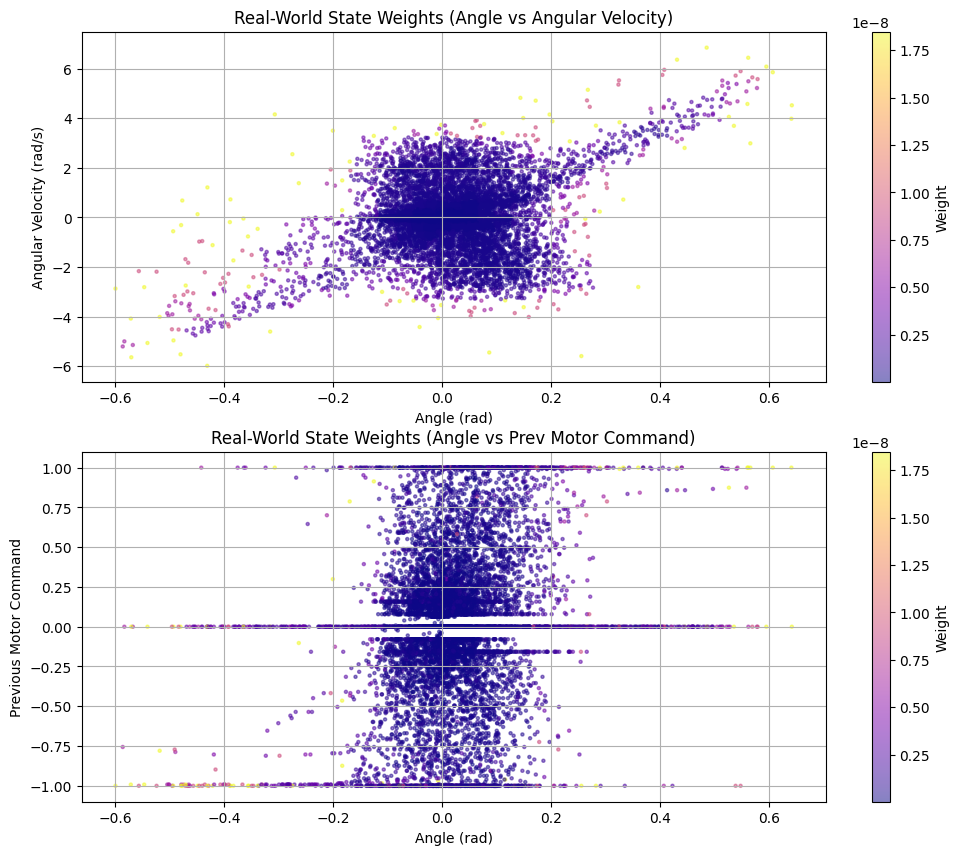

In [11]:
# Analyze the class distribution of real data
real_distribution = SimNetTrainer.analyze_class_distribution(
    real_train_data, 
    num_bins=num_bins, 
    strategy=strategy
)

print("Real-world data distribution statistics:")
for key, value in real_distribution.items():
    if isinstance(value, tuple):
        print(f"  {key}: ({value[0]:.4f}, {value[1]:.4f})")
    else:
        print(f"  {key}: {value:.4f}")

# Visualize class weights for real data
real_states = real_train_data['states']
real_weights = SimNetTrainer.calculate_class_weights(
    real_states, 
    num_bins=num_bins, 
    strategy=strategy
)

# Create multi-dimensional visualization for real data
plt.figure(figsize=(12, 10))

# Plot angle vs angular velocity 
plt.subplot(2, 1, 1)
plt.scatter(real_states[:, 0], real_states[:, 1], c=real_weights, cmap='plasma', alpha=0.5, s=5)
plt.colorbar(label='Weight')
plt.title(f'Real-World State Weights (Angle vs Angular Velocity)')
plt.xlabel('Angle (rad)')
plt.ylabel('Angular Velocity (rad/s)')
plt.grid(True)

# Plot angle vs previous motor command
plt.subplot(2, 1, 2)
plt.scatter(real_states[:, 0], real_states[:, 2], c=real_weights, cmap='plasma', alpha=0.5, s=5)
plt.colorbar(label='Weight')
plt.title(f'Real-World State Weights (Angle vs Prev Motor Command)')
plt.xlabel('Angle (rad)')
plt.ylabel('Previous Motor Command')
plt.grid(True)

## Balance Real-World Data

Original real dataset size: 10190 samples
Balanced real dataset size: 444548 samples


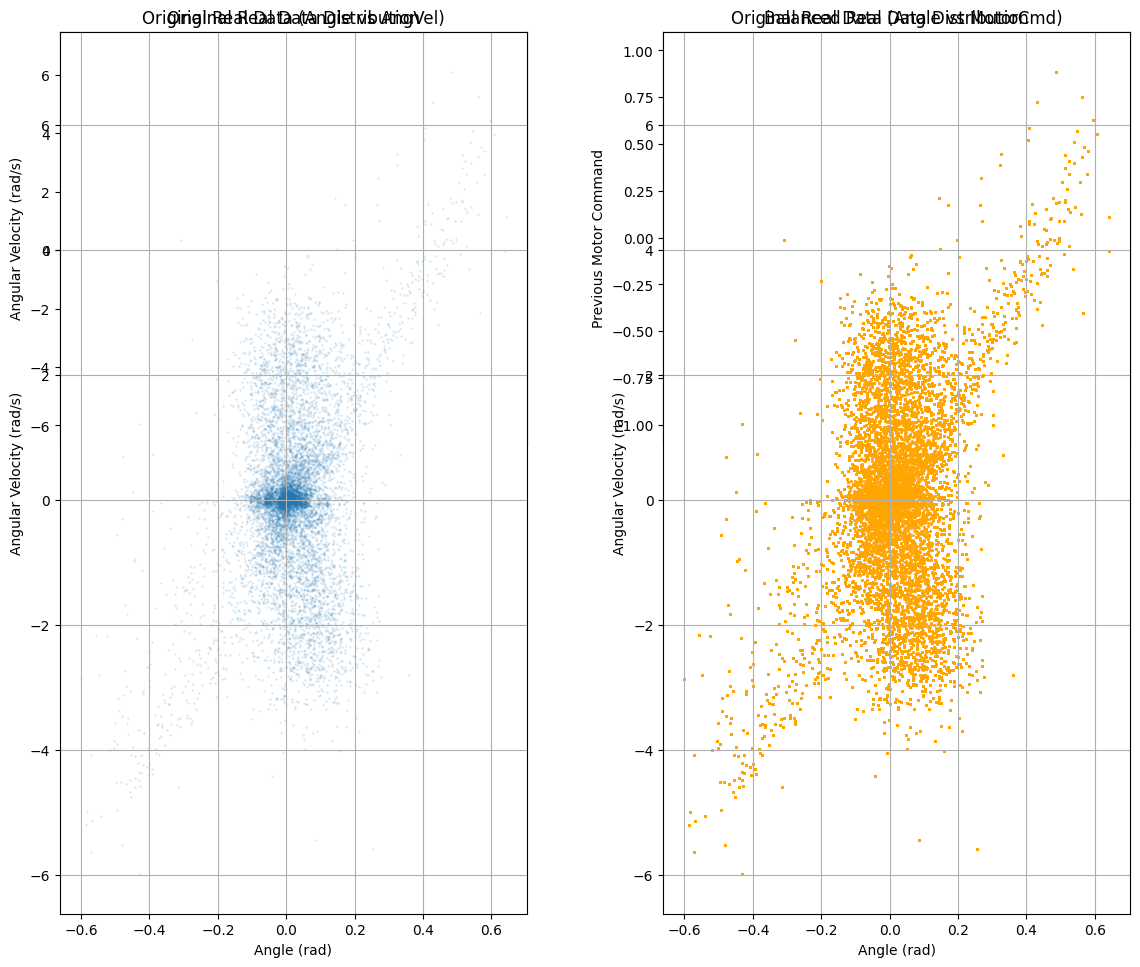

In [12]:
# Apply balancing to real data as well
balanced_real_train_data = SimNetTrainer.create_balanced_dataset(
    real_train_data, 
    num_bins=num_bins, 
    strategy=strategy
)

print(f"Original real dataset size: {len(real_train_data['states'])} samples")
print(f"Balanced real dataset size: {len(balanced_real_train_data['states'])} samples")

# Compare distributions with 3D state
plt.figure(figsize=(12, 10))

# Angle vs Angular Velocity for original data
plt.subplot(2, 2, 1)
plt.scatter(real_train_data['states'][:, 0], real_train_data['states'][:, 1], alpha=0.1, s=1)
plt.title('Original Real Data (Angle vs AngVel)')
plt.xlabel('Angle (rad)')
plt.ylabel('Angular Velocity (rad/s)')
plt.grid(True)

# Angle vs Previous Motor Command for original data
plt.subplot(2, 2, 2)
plt.scatter(real_train_data['states'][:, 0], real_train_data['states'][:, 2], alpha=0.1, s=1)
plt.title('Original Real Data (Angle vs MotorCmd)')
plt.xlabel('Angle (rad)')
plt.ylabel('Previous Motor Command')
plt.grid(True)

plt.subplot(1, 2, 1)
plt.scatter(real_train_data['states'][:, 0], real_train_data['states'][:, 1], alpha=0.1, s=1)
plt.title('Original Real Data Distribution')
plt.xlabel('Angle (rad)')
plt.ylabel('Angular Velocity (rad/s)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(balanced_real_train_data['states'][:, 0], balanced_real_train_data['states'][:, 1], 
            alpha=0.1, s=1, c='orange')
plt.title('Balanced Real Data Distribution')
plt.xlabel('Angle (rad)')
plt.ylabel('Angular Velocity (rad/s)')
plt.grid(True)

plt.tight_layout()
plt.savefig(log_dir / "balanced_real_vs_original_distribution.png")
plt.show()

## Fine-tune on Real Data

In [13]:
# Fine-tune on real data
real_history = trainer.train(
    train_data=balanced_real_train_data,
    val_data=real_val_data,
    is_finetuning=True,
    log_dir=log_dir / 'real'
)

Epoch 1/10 - Train Loss: 0.324374 - Val Loss: 0.236727
Epoch 2/10 - Train Loss: 0.257161 - Val Loss: 0.193886
Epoch 3/10 - Train Loss: 0.243746 - Val Loss: 0.180476
Epoch 4/10 - Train Loss: 0.238921 - Val Loss: 0.175785
Epoch 00035: reducing learning rate of group 0 to 5.0000e-06.
Epoch 5/10 - Train Loss: 0.237037 - Val Loss: 0.173162
Epoch 6/10 - Train Loss: 0.247044 - Val Loss: 0.186575
Epoch 7/10 - Train Loss: 0.251359 - Val Loss: 0.181917
Epoch 8/10 - Train Loss: 0.247983 - Val Loss: 0.178190
Epoch 9/10 - Train Loss: 0.245393 - Val Loss: 0.175021
Epoch 00040: reducing learning rate of group 0 to 2.5000e-06.
Epoch 10/10 - Train Loss: 0.243339 - Val Loss: 0.172312


## Compare Distributions Between Generated and Real Data

In [14]:
# # Create scatter plots and heatmaps to visualize the distribution of data
# plt.figure(figsize=(16, 12))

# # Original physics data distribution
# plt.subplot(2, 2, 1)
# plt.scatter(train_data['states'][:, 0], train_data['states'][:, 1], alpha=0.1, s=1)
# plt.title('Original Physics Data Distribution')
# plt.xlabel('Theta (rad)')
# plt.ylabel('Theta dot (rad/s)')
# plt.grid(True)

# # Original real data distribution
# plt.subplot(2, 2, 2)
# plt.scatter(real_train_data['states'][:, 0], real_train_data['states'][:, 1], alpha=0.2, s=3, c='orange')
# plt.title('Original Real-World Data Distribution')
# plt.xlabel('Theta (rad)')
# plt.ylabel('Theta dot (rad/s)')
# plt.grid(True)

# # Balanced physics data distribution
# plt.subplot(2, 2, 3)
# plt.scatter(balanced_train_data['states'][:, 0], balanced_train_data['states'][:, 1], alpha=0.1, s=1, c='green')
# plt.title('Balanced Physics Data Distribution')
# plt.xlabel('Theta (rad)')
# plt.ylabel('Theta dot (rad/s)')
# plt.grid(True)

# # Balanced real data distribution
# plt.subplot(2, 2, 4)
# plt.scatter(balanced_real_train_data['states'][:, 0], balanced_real_train_data['states'][:, 1], 
#             alpha=0.2, s=3, c='purple')
# plt.title('Balanced Real-World Data Distribution')
# plt.xlabel('Theta (rad)')
# plt.ylabel('Theta dot (rad/s)')
# plt.grid(True)

# plt.tight_layout()
# plt.savefig(log_dir / "comparison_original_vs_balanced.png")
# plt.show()

## Analyze Predictions

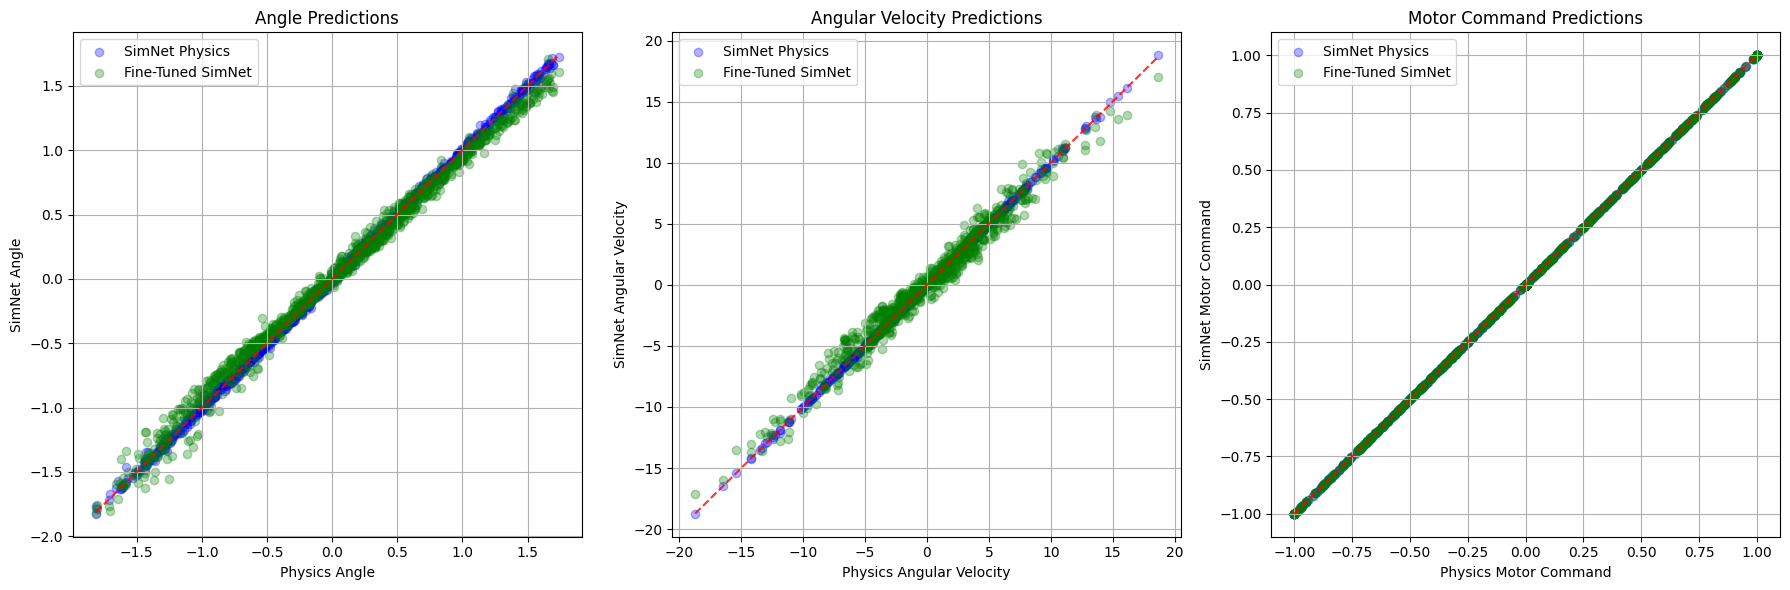

In [15]:
test_states = val_data["states"][:1000]
test_actions = val_data["actions"][:1000]
physics_preds = val_data["next_states"][:1000]  # The actual next states from the physics data

# Get SimNet predictions
simnet_preds = []
simnet_physics_preds = []
for s, a in zip(test_states, test_actions):
    s_tensor = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    a_tensor = torch.tensor(a, dtype=torch.float32).unsqueeze(0)
    pred_next = trainer.simnet(s_tensor, a_tensor).detach().numpy()[0]
    simnet_preds.append(pred_next)
    pred_next_physics = simnet_physics(s_tensor, a_tensor).detach().numpy()[0]
    simnet_physics_preds.append(pred_next_physics)
simnet_preds = np.array(simnet_preds)
simnet_physics_preds = np.array(simnet_physics_preds)


# Custom function to plot 3D state predictions (focus on the first two elements)
def plot_3d_state_predictions(physics_preds, simnet_preds, simnet_physics_preds, save_path=None):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot angle predictions
    axes[0].scatter(physics_preds[:, 0], simnet_physics_preds[:, 0], alpha=0.3, label="SimNet Physics", color="blue")
    axes[0].scatter(physics_preds[:, 0], simnet_preds[:, 0], alpha=0.3, label="Fine-Tuned SimNet", color="green")
    min_val, max_val = min(physics_preds[:, 0]), max(physics_preds[:, 0])
    axes[0].plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8)
    axes[0].set_xlabel("Physics Angle")
    axes[0].set_ylabel("SimNet Angle")
    axes[0].set_title("Angle Predictions")
    axes[0].grid(True)
    axes[0].legend()

    # Plot angular velocity predictions
    axes[1].scatter(physics_preds[:, 1], simnet_physics_preds[:, 1], alpha=0.3, label="SimNet Physics", color="blue")
    axes[1].scatter(physics_preds[:, 1], simnet_preds[:, 1], alpha=0.3, label="Fine-Tuned SimNet", color="green")
    min_val, max_val = min(physics_preds[:, 1]), max(physics_preds[:, 1])
    axes[1].plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8)
    axes[1].set_xlabel("Physics Angular Velocity")
    axes[1].set_ylabel("SimNet Angular Velocity")
    axes[1].set_title("Angular Velocity Predictions")
    axes[1].grid(True)
    axes[1].legend()

    # Plot motor command predictions
    axes[2].scatter(physics_preds[:, 2], simnet_physics_preds[:, 2], alpha=0.3, label="SimNet Physics", color="blue")
    axes[2].scatter(physics_preds[:, 2], simnet_preds[:, 2], alpha=0.3, label="Fine-Tuned SimNet", color="green")
    min_val, max_val = min(physics_preds[:, 2]), max(physics_preds[:, 2])
    axes[2].plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8)
    axes[2].set_xlabel("Physics Motor Command")
    axes[2].set_ylabel("SimNet Motor Command")
    axes[2].set_title("Motor Command Predictions")
    axes[2].grid(True)
    axes[2].legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)

    return fig


# Use custom function for the 3D states
fig = plot_3d_state_predictions(
    physics_preds=physics_preds,
    simnet_preds=simnet_preds,
    simnet_physics_preds=simnet_physics_preds,
    save_path=log_dir / "prediction_comparison_3d.png",
)
plt.show()

## Evaluate Learning Curves

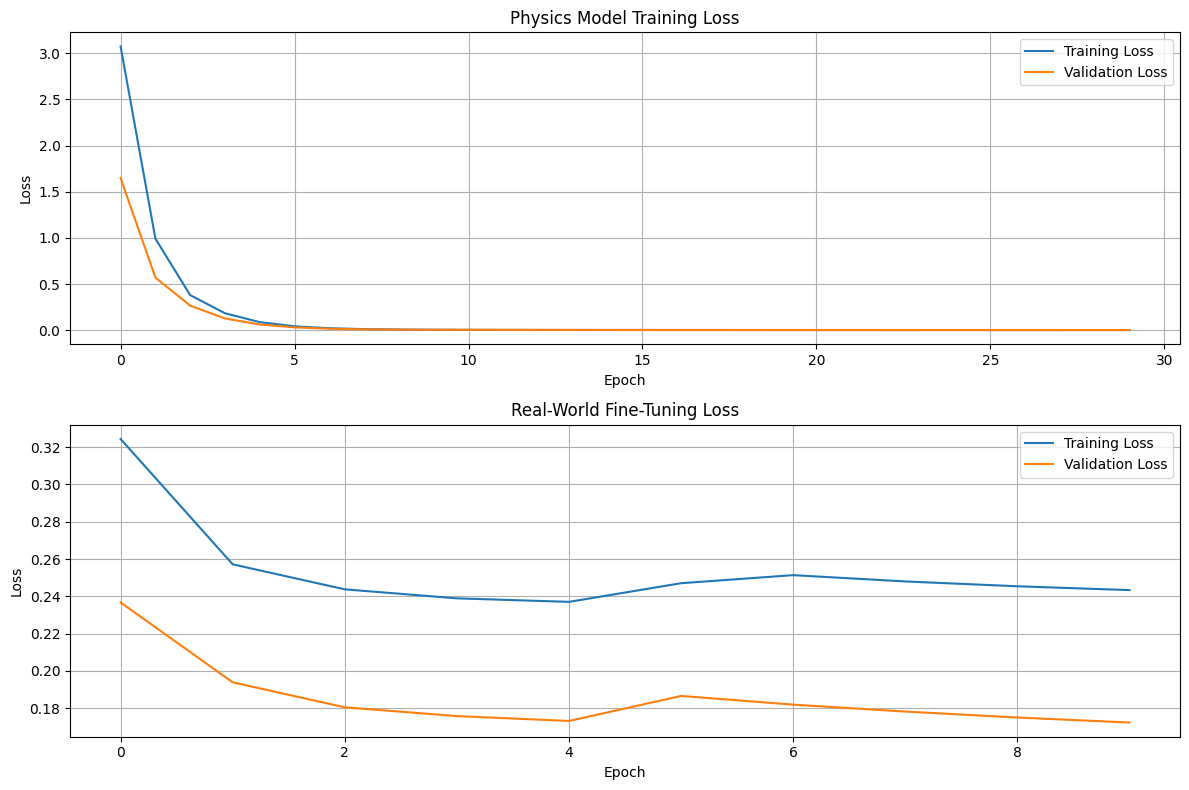

In [16]:
# Extract training losses from history data
physics_train_losses = [epoch['train_loss'] for epoch in physics_history]
physics_val_losses = [epoch['val_loss'] for epoch in physics_history]
real_train_losses = [epoch['train_loss'] for epoch in real_history]
real_val_losses = [epoch['val_loss'] for epoch in real_history]

# Create figure for loss plots
plt.figure(figsize=(12, 8))

# Plot physics training loss
plt.subplot(2, 1, 1)
plt.plot(physics_train_losses, label='Training Loss')
plt.plot(physics_val_losses, label='Validation Loss')
plt.title('Physics Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot real-world fine-tuning loss
plt.subplot(2, 1, 2)
plt.plot(real_train_losses, label='Training Loss')
plt.plot(real_val_losses, label='Validation Loss')
plt.title('Real-World Fine-Tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(log_dir / "loss_curves.png")
plt.show()

## Evaluate Performance Across State-Space

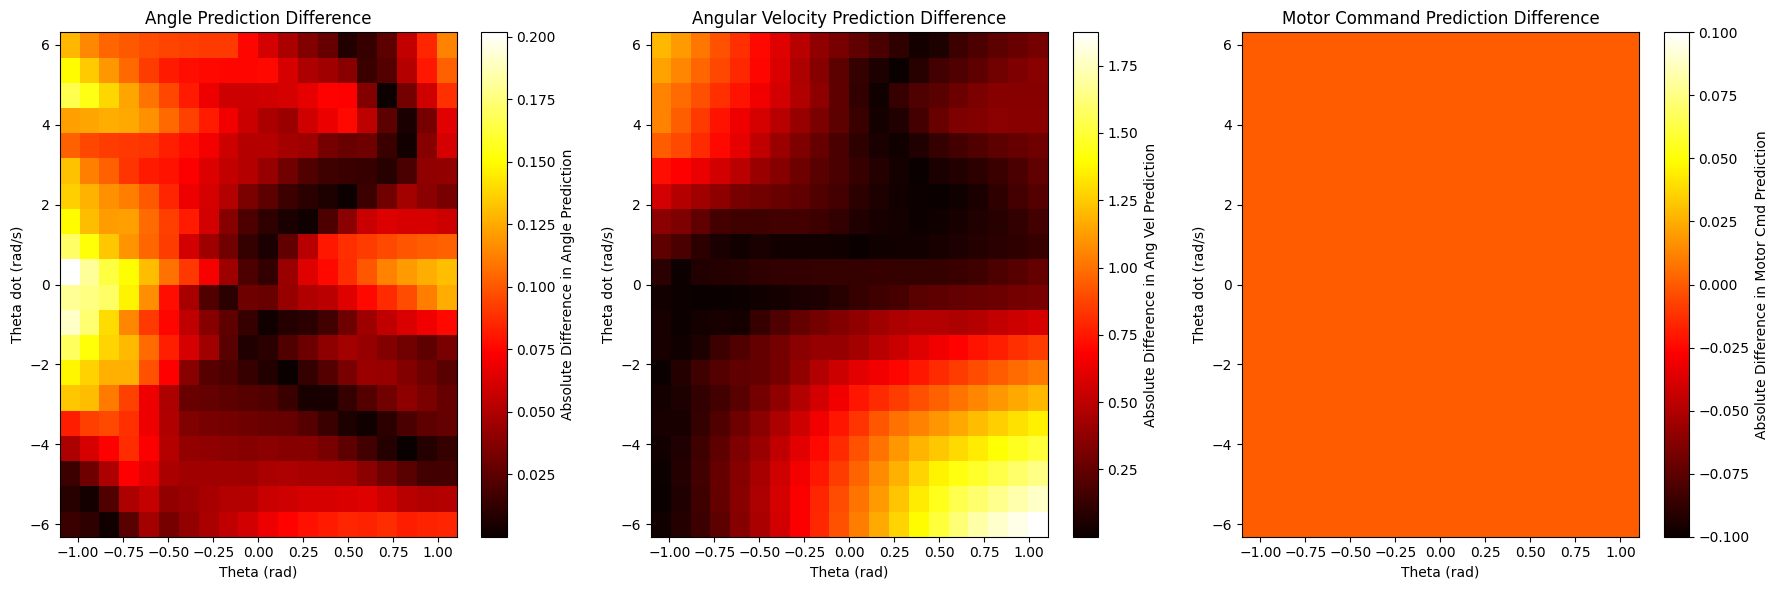

In [17]:
# Create a grid of test points across the state space for the first two dimensions
# Use a fixed value for the previous motor command dimension (0.0)
theta_range = np.linspace(-np.pi / 3, np.pi / 3, 20)
theta_dot_range = np.linspace(-6, 6, 20)
prev_cmd_value = 0.0  # Fixed value for previous motor command
theta_grid, theta_dot_grid = np.meshgrid(theta_range, theta_dot_range)

# Flatten the grid and add the third dimension (previous motor command)
test_grid_states = np.column_stack(
    (
        theta_grid.flatten(),
        theta_dot_grid.flatten(),
        np.ones(len(theta_grid.flatten())) * prev_cmd_value,  # Add fixed previous motor command
    )
)

# Test both models on this grid with a zero action
test_grid_actions = np.zeros((len(test_grid_states), 1))

# Get predictions from both models
grid_simnet_preds = []
grid_simnet_physics_preds = []

for s, a in zip(test_grid_states, test_grid_actions):
    s_tensor = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    a_tensor = torch.tensor(a, dtype=torch.float32).unsqueeze(0)

    # Get prediction from fine-tuned model
    pred_next = trainer.simnet(s_tensor, a_tensor).detach().numpy()[0]
    grid_simnet_preds.append(pred_next)

    # Get prediction from physics-only model
    pred_next_physics = simnet_physics(s_tensor, a_tensor).detach().numpy()[0]
    grid_simnet_physics_preds.append(pred_next_physics)

grid_simnet_preds = np.array(grid_simnet_preds)
grid_simnet_physics_preds = np.array(grid_simnet_physics_preds)

# Calculate the absolute difference between the models
prediction_diff = np.abs(grid_simnet_preds - grid_simnet_physics_preds)
diff_angle = prediction_diff[:, 0].reshape(theta_dot_grid.shape)
diff_angular_vel = prediction_diff[:, 1].reshape(theta_dot_grid.shape)
diff_motor_cmd = prediction_diff[:, 2].reshape(theta_dot_grid.shape)

# Plot the difference as a heatmap
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.pcolormesh(theta_grid, theta_dot_grid, diff_angle, cmap="hot")
plt.colorbar(label="Absolute Difference in Angle Prediction")
plt.title("Angle Prediction Difference")
plt.xlabel("Theta (rad)")
plt.ylabel("Theta dot (rad/s)")

plt.subplot(1, 3, 2)
plt.pcolormesh(theta_grid, theta_dot_grid, diff_angular_vel, cmap="hot")
plt.colorbar(label="Absolute Difference in Ang Vel Prediction")
plt.title("Angular Velocity Prediction Difference")
plt.xlabel("Theta (rad)")
plt.ylabel("Theta dot (rad/s)")

plt.subplot(1, 3, 3)
plt.pcolormesh(theta_grid, theta_dot_grid, diff_motor_cmd, cmap="hot")
plt.colorbar(label="Absolute Difference in Motor Cmd Prediction")
plt.title("Motor Command Prediction Difference")
plt.xlabel("Theta (rad)")
plt.ylabel("Theta dot (rad/s)")

plt.tight_layout()
plt.savefig(log_dir / "prediction_difference_heatmap.png")
plt.show()

## Save Final Model

In [18]:
# Save trained SimNet
torch.save({
    'state_dict': trainer.simnet.state_dict(),
    'physics_history': physics_history,
    'real_history': real_history,
    'config': simnet_config,
    'metadata': {
        'state_dim': env.observation_space.shape[0],
        'action_dim': env.action_space.shape[0],
        'hidden_dims': simnet_config['model']['hidden_dims']
    }
}, log_dir / 'simnet_final.pt')
